In [1]:
import os
import sys
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md
import pandas as pd

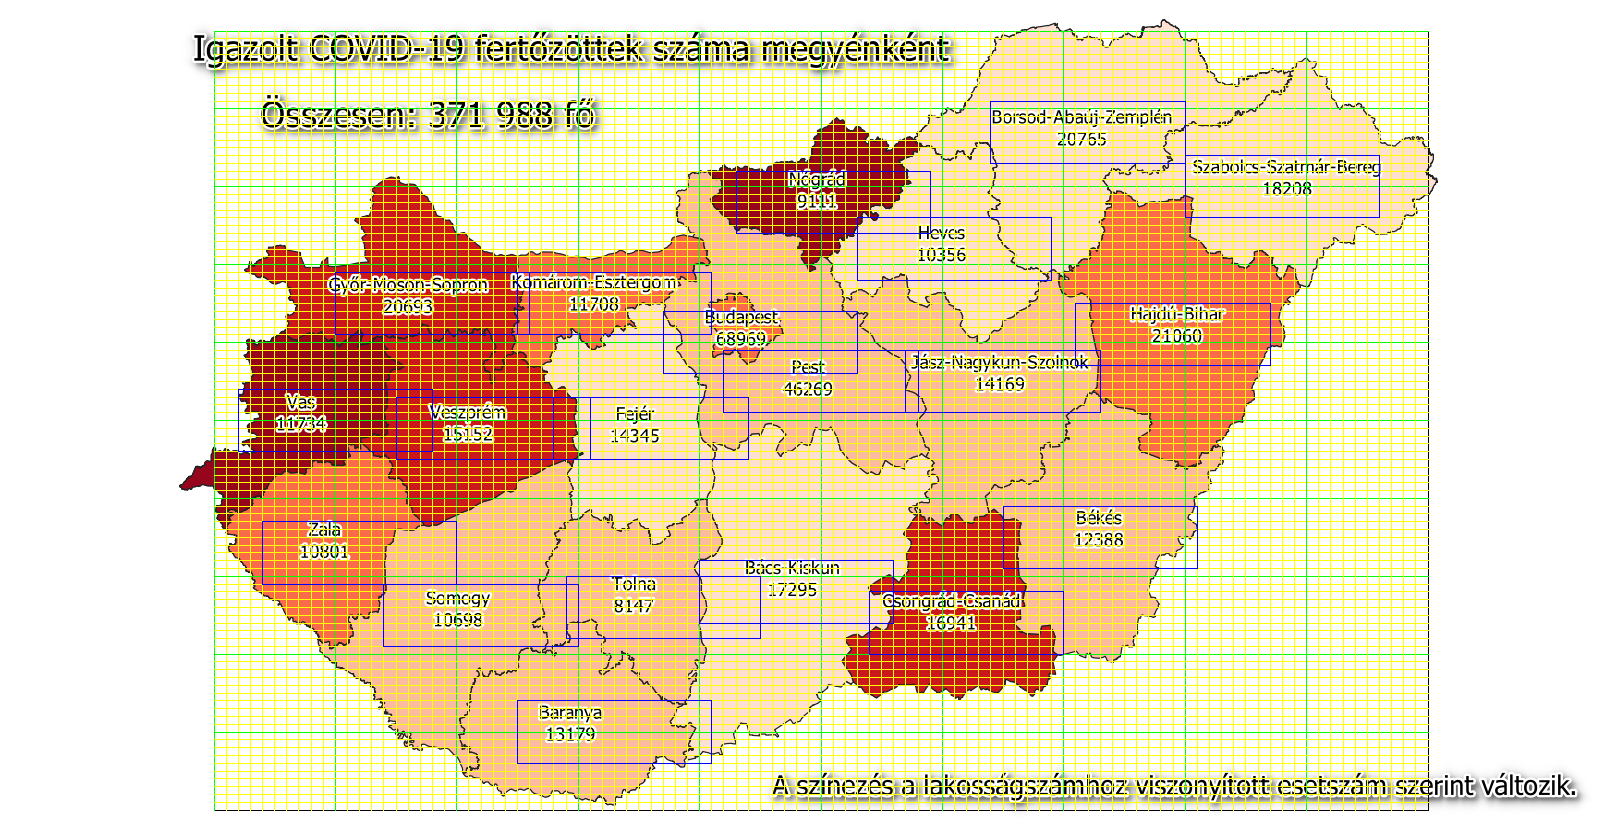

Sum: 371988


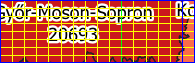

Győr-Moson-Sopron: 20693


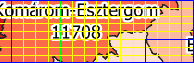

Komárom-Esztergom: 11708


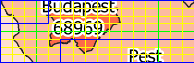

Budapest: 68969


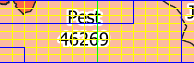

Pest: 46269


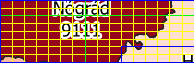

Nógrád: 9111


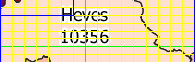

Heves: 10356


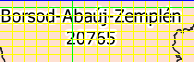

Borsod-Abaúj-Zemplén: 20765


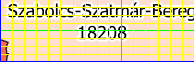

Szabolcs-Szatmár-Bereg: 18208


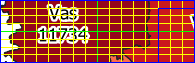

Vas: 11734


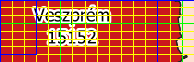

Veszprém: 15152


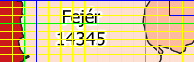

Fejér: 14345


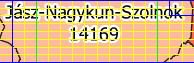

Jász-Nagykun-Szolnok: 14169


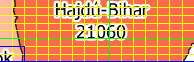

Hajdú-Bihar: 21060


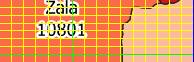

Zala: 10801


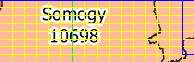

Somogy: 10698


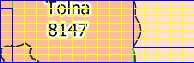

Tolna: 8147


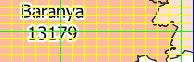

Baranya: 13179


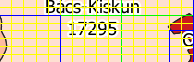

Bács-Kiskun: 17295


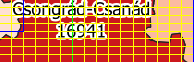

Csongrád: 16941


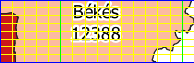

Békés: 12388


[['2021-02-04', '20693', 'Győr-Moson-Sopron', 'map_2021-02-04.png'],
 ['2021-02-04', '11708', 'Komárom-Esztergom', 'map_2021-02-04.png'],
 ['2021-02-04', '68969', 'Budapest', 'map_2021-02-04.png'],
 ['2021-02-04', '46269', 'Pest', 'map_2021-02-04.png'],
 ['2021-02-04', '9111', 'Nógrád', 'map_2021-02-04.png'],
 ['2021-02-04', '10356', 'Heves', 'map_2021-02-04.png'],
 ['2021-02-04', '20765', 'Borsod-Abaúj-Zemplén', 'map_2021-02-04.png'],
 ['2021-02-04', '18208', 'Szabolcs-Szatmár-Bereg', 'map_2021-02-04.png'],
 ['2021-02-04', '11734', 'Vas', 'map_2021-02-04.png'],
 ['2021-02-04', '15152', 'Veszprém', 'map_2021-02-04.png'],
 ['2021-02-04', '14345', 'Fejér', 'map_2021-02-04.png'],
 ['2021-02-04', '14169', 'Jász-Nagykun-Szolnok', 'map_2021-02-04.png'],
 ['2021-02-04', '21060', 'Hajdú-Bihar', 'map_2021-02-04.png'],
 ['2021-02-04', '10801', 'Zala', 'map_2021-02-04.png'],
 ['2021-02-04', '10698', 'Somogy', 'map_2021-02-04.png'],
 ['2021-02-04', '8147', 'Tolna', 'map_2021-02-04.png'],
 ['2021-0

In [60]:
my_map = md.MapObject(data_dir="{}/data".format(base_dir), config_dir="{}/model".format(base_dir))
display(my_map.show(date="2021-02-04", percent=True))
data_json = my_map.input_map()
data_json

In [61]:
sum_row = 0
for row in data_json:
    sum_row += int(row[1])
print(sum_row)

371988


In [62]:
newDf = pd.DataFrame(data_json, columns=["date","confirmed","region","image"])
newDf["date"] = newDf["date"].apply(lambda cell: pd.Timestamp(cell))
# Agregate with already existing df (w/o given date)
allDf = pd.concat([newDf,my_map._df[my_map._df["date"]!=newDf["date"][0]]], sort=False)
allDf

,date,confirmed,region,image
0,2021-02-04,20693,Győr-Moson-Sopron,map_2021-02-04.png
1,2021-02-04,11708,Komárom-Esztergom,map_2021-02-04.png
2,2021-02-04,68969,Budapest,map_2021-02-04.png
3,2021-02-04,46269,Pest,map_2021-02-04.png
4,2021-02-04,9111,Nógrád,map_2021-02-04.png
...,...,...,...,...
6155,2020-04-02,21,Csongrád,NaN
6156,2020-04-02,6,Borsod-Abaúj-Zemplén,NaN
6157,2020-04-02,27,Szabolcs-Szatmár-Bereg,NaN
6158,2020-04-02,10,Hajdú-Bihar,NaN


In [63]:
allDf.to_csv("{}/data/map_data/map_dataframe_per_megye_{}.csv".format(base_dir, newDf["date"][0].date()), index=False)

In [64]:
allDf.to_csv("{}/data/map_data/map_dataframe_per_megye.csv".format(base_dir), index=False)

# Analyse

# Source: https://hu.wikipedia.org/wiki/Magyarorsz%C3%A1g_megy%C3%A9i
enterData = False
if enterData:
    fields = ["Népesség","Terület","Népsűrűség"]
    jsonData = []
    for region in regions:
        jsonDict = {}
        jsonDict["Megye"] = region
        print(region)
        for field in fields:
            value = input(field+": ")
            jsonDict[field] = value
        jsonData.append(jsonDict)
    # Save to file
    baseDf = pd.DataFrame(jsonData)
    baseDf.columns = ["region","population","area","density"]
    baseDf.to_csv("{}/data/base/base_dataframe_per_megye.csv".format(base_dir), index=False)

# Analyse

In [2]:
baseDf = pd.read_csv("{}/data/base/base_dataframe_per_megye.csv".format(base_dir), delimiter=",")

In [3]:
df = pd.read_csv("{}/data/map_data/map_dataframe_per_megye.csv".format(base_dir), delimiter=",", parse_dates=["date"])
del df["image"]
dfBp = df.groupby("date").sum().reset_index()
dfBp["region"] = "Hungary"
dfAll = pd.concat([df, dfBp], sort=False)
dfAll["new"] = dfAll.apply(
    lambda row: row["confirmed"] - dfAll[(dfAll["date"]<row["date"]) & (dfAll["region"]==row["region"])]["confirmed"].max(), 
    axis=1
)
dfAll["dailyFactor"] = dfAll.apply(
    lambda row: row["confirmed"] / dfAll[(dfAll["date"]<row["date"]) & (dfAll["region"]==row["region"])]["confirmed"].max(), 
    axis=1
)
dfAll["dailyFactor"] = round(dfAll["dailyFactor"],2)
dfAll["doublingFactor"] = round(2/dfAll["dailyFactor"],2)
dfAll["increase"] = dfAll["new"] / dfAll["confirmed"]

dfSIR = dfAll[
    (dfAll["region"]!="Hungary") & (dfAll["date"]>="2020-10-01")
][["date","region","confirmed","new"]].copy()
dfSIR["population"] = dfSIR["region"].apply(lambda cell: baseDf[baseDf["region"]==cell]["population"].max())
dfSIR["area"] = dfSIR["region"].apply(lambda cell: baseDf[baseDf["region"]==cell]["area"].max())
dfSIR["density"] = dfSIR["region"].apply(lambda cell: baseDf[baseDf["region"]==cell]["density"].max())
dfSIR["ppm_confirmed"] = round(dfSIR["confirmed"] / dfSIR["population"] * 1000000, 4)

NameError: name 'newDf' is not defined

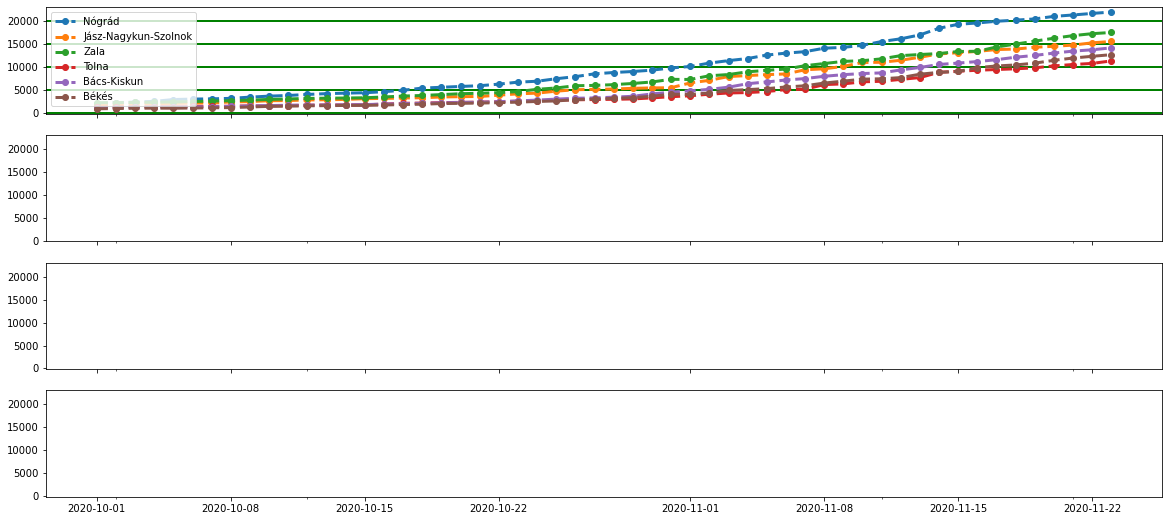

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from colorsys import hls_to_rgb
import colorsys
import numpy as np 

def get_distinct_colors(n):
    colors = []
    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))

    HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    colors = list(RGB_tuples)
    return colors

densities = [50,75,100,1000,10000]
cm = plt.cm.get_cmap('tab20').colors
cm = get_distinct_colors(25)
fig, ax = plt.subplots(nrows=len(densities)-1, ncols=1, figsize=(20,10), sharex=True, sharey=True)
for i in range(0,len(densities)-1):
    dfSIR2 = dfSIR[(dfSIR["density"]>=densities[i]) & (dfSIR["density"]<densities[i+1])]
    #ax[i].set_yscale("log")
    for region in dfSIR2["region"].unique():
        if dfSIR2[dfSIR2["region"]==region]["ppm_confirmed"].max()>400:
            dfSIR2[dfSIR2["region"]==region].plot(
                x="date",y="ppm_confirmed",
                ax=ax[i],
                style="o--", 
                linestyle="--", linewidth=3, #color=cm[colindex],
                label=region
            )
    ax[i].grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1)
    ax[i].grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2)
    yRange = ax[i].get_ylim()[1]-ax[i].get_ylim()[0]
    for region in dfSIR2["region"].unique():
        if dfSIR2[dfSIR2["region"]==region]["ppm_confirmed"].max()>400:
            ax[i].text(
                dfSIR2[(dfSIR2["region"]==region) & (dfSIR2["date"]==newDf["date"][0])]["date"].max()+pd.Timedelta(0.5, "days"),
                dfSIR2[(dfSIR2["region"]==region) & (dfSIR2["date"]==newDf["date"][0])]["ppm_confirmed"].max() + yRange*0.01,
                "{} - {}".format(
                    round(dfSIR2[(dfSIR2["region"]==region) & (dfSIR2["date"]==newDf["date"][0])]["ppm_confirmed"].max(),2),
                    region
                ), fontsize=12)
    ax[i].set_xlim(dfSIR2["date"].min(),dfSIR2["date"].max()+pd.Timedelta(5, "days"))
    ax[i].get_legend().remove()
    ax[i].set_title("Ppm confirmed (Density {}-{})".format(densities[i], densities[i+1]))
    ax[i].set_ylabel("Ppm")
plt.show()

In [ ]:
dfSIR[(dfSIR["region"]=="Budapest") & (dfSIR["date"]>"2020-10-01")]